In [ ]:
import numpy as np
import matplotlib.pyplot as plt

_ = np.seterr(divide="raise")

# Evaluation criteria

## Some general points to consider when choosing an evaluation metric:

### Does scale matter?
If you need to compare forecast accuracy across datasets or across time series with different scales, choose a scale-independent metric. Common options:
- MAPE (Mean Absolute Percentage Error)
- sMAPE (Symmetric MAPE)
- MASE (Mean Absolute Scaled Error)
- RMSSE (Root Mean Squared Scaled Error)

If you're only evaluating performance within a single time series, scale-dependent metrics like MAE (Mean Absolute Error) or RMSE (Root Mean Squared Error) may be more appropriate and stable.

### 

## Scale independent measures

In [ ]:
# How do these metrics behave with y_true = 0 ?
# How do these metrics behave with y_true close to 0 ?
# Symmmetry of errors: "MAPE and MdAPE also have the disadvantage that they put a heavier penalty on positive errors than on negative errors".


In [ ]:
import pandas as pd

In [ ]:
y_train = pd.Series(np.arange(21))
y_train.to_numpy()[7:].shape
y_train.to_numpy()[:-7].shape

### MAPE

In [ ]:
# y_true = 0

y_true = np.array([5, 0, 4, 3, 1])
y_hat = np.array([1, 3, 5, 2, 1])
np.mean(np.abs((y_true - y_hat) / y_true * 100))

In [ ]:
y_true = np.array([4, 3, 1, 7, 8])
y_hat = np.array([1, 3, 5, 2, 1])
np.mean(np.abs((y_true - y_hat) / y_true * 100))

In [ ]:
y_true = np.array([0.1, 0.01, 0.3, 0.5, 0.2])
y_hat = np.array([0.5, 0.2, 0.3, 0.1, 0.1])
np.mean(np.abs((y_true - y_hat) / y_true * 100))

In [ ]:
n_samples = 1000
errors = []
y_true = np.random.normal(size=n_samples) / 1e6
y_hat = np.random.normal(size=n_samples) / 1e6

In [ ]:
plt.hist(y_true)

In [ ]:
y_true, y_hat = 0.1, 0.2
error = y_true - y_hat
pct_error = error / y_true

print("Error: ", error)
print("Pct Error: ", pct_error)

In [ ]:


# Set seed for reproducibility
np.random.seed(42)

# Simulate actual values (Y_t) and predictions (Y_hat)
# Mostly around 100, but a few near zero
Y_t = np.concatenate([np.random.normal(100, 10, 95), np.random.uniform(0.01, 1, 5)])
Y_hat = Y_t + np.random.normal(0, 5, len(Y_t))  # Add some noise

# Calculate percentage error
percentage_error = np.abs((Y_t - Y_hat) / Y_t) * 100

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import MSTL
from bikes.utils.preprocess import Scaler
from bikes.models.ets import ExponentialSmoothingLearner
from bikes.models.sarima import SARIMASequenceLearner
from bikes.models.prophet import ProphetSequenceLearner
from bikes.models.theta import ThetaSequenceLearner
from bikes.models.prophet import ProphetSequenceLearner
from bikes.models.rnn import RNNSequenceLearner

from bikes.evaluate import run_evaluation
from bikes.utils.preprocess import get_tensor_train_dataset

import torch
import torch.nn as nn

In [3]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["date"])

In [22]:
location = "Nelson Street"

location_df = cycle_counts[cycle_counts["location"] == location]
location_df = location_df.set_index("date").sort_index()

ts = get_tensor_train_dataset(location_df["count"], 90, 30)

In [25]:
X, y = ts.tensors

In [27]:
X.size()

torch.Size([976, 90, 1])

In [28]:
y.size()

torch.Size([976, 90, 30])

In [30]:
lstm = nn.LSTM(input_size=1, hidden_size=25, batch_first=True)
linear = nn.Linear(in_features=25, out_features=30)

out, _ = lstm(X)

In [33]:
linear(out).shape

torch.Size([976, 90, 30])

In [20]:
all_forecasts = run_evaluation(cycle_counts_df=cycle_counts, forecast_dir=Path("/Users/lukasmalms/Desktop/bikes"))

/Users/lukasmalms/faculty/sequence-learners/bikes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasmalms/faculty/sequence-learners/bikes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasmalms/faculty/sequence-learners/bikes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukasmalms/faculty/sequence-learners/bikes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/lukas

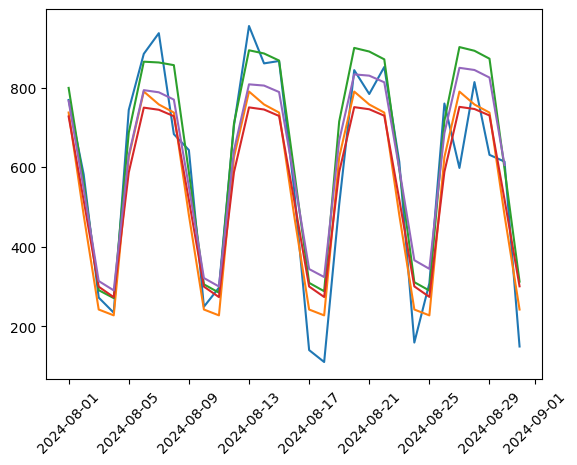

In [17]:
fold_idx = 0
models = all_forecasts[all_forecasts["fold_idx"] == fold_idx]["model"].unique()

fig, ax = plt.subplots()

for i, model in enumerate(models):    
    model_df = all_forecasts[
        (all_forecasts["fold_idx"] == fold_idx)
        & (all_forecasts["model"] == model)
    ]
    if i == 0:
        ax.plot(model_df["date"].values, model_df["actual"].values)
    ax.plot(model_df["date"].values, model_df["forecast"].values)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [13]:
model_df

,date,location,actual,forecast,model,fold_idx
0,2024-08-01,Nelson Street,769,737.430095,ExponentialSmoothingLearner,0
1,2024-08-02,Nelson Street,582,479.481484,ExponentialSmoothingLearner,0
2,2024-08-03,Nelson Street,272,242.022248,ExponentialSmoothingLearner,0
3,2024-08-04,Nelson Street,234,227.294007,ExponentialSmoothingLearner,0
4,2024-08-05,Nelson Street,744,625.231185,ExponentialSmoothingLearner,0
5,2024-08-06,Nelson Street,885,790.229293,ExponentialSmoothingLearner,0
6,2024-08-07,Nelson Street,937,757.734861,ExponentialSmoothingLearner,0
7,2024-08-08,Nelson Street,683,737.383704,ExponentialSmoothingLearner,0
8,2024-08-09,Nelson Street,643,479.451621,ExponentialSmoothingLearner,0
9,2024-08-10,Nelson Street,249,242.007326,ExponentialSmoothingLearner,0


In [ ]:
location = "Nelson Street"

location_df = cycle_counts[cycle_counts["location"] == location].copy()
location_df = location_df.set_index("date").sort_index()

train_df = location_df.loc[:val_start]
val_df = location_df.loc[val_start: val_end]

In [ ]:
model = SARIMASequenceLearner(
    horizon=31,
    order=(1, 1, 2),
    seasonal_order=(1, 1, 1, 7),
    freq="D",
)

In [ ]:
model.fit(train_df.loc[:, "count"])
y_hat = model.predict()

In [ ]:
ax = y_hat.plot()
val_df.loc[:, "count"].plot(ax=ax)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
y_train = train_df.loc[:, "count"]
plot_acf(y_train.diff(7).diff(1).dropna());

In [ ]:
plot_pacf(y_train.diff(7).diff(1).dropna());

In [ ]:
y_train.plot()

In [ ]:
y_train.diff(7).dropna().plot(kind="hist")

In [ ]:
forecast_df.plot(y=["count", "ExponentialSmoothingLearner", "SARIMASequenceLearner"])

In [ ]:
pd.merge(
    left=val_df,
    right=y_hat_ets,
    left_index=True,
    right_index=True
)

In [ ]:
fig, ax = plt.subplots()

ax.plot(
    train_df.index.values[-100:],
    train_df["count"].values[-100:],
)
ax.plot(
    val_df.index.values,
    val_df["count"].values,
)

ets = ExponentialSmoothingLearner(horizon=31, trend="add", damped_trend=True, seasonal="mul", seasonal_periods=7, freq="D")
ets.fit(train_df["count"])
y_hat_ets = ets.predict()

ax.plot(
    y_hat_ets.index.values,
    y_hat_ets.values,
)

In [ ]:
y_hat_ets

In [ ]:
i = 5
loc = sorted(cycle_counts["location"].unique())[i]a

location_df = cycle_counts[cycle_counts["location"] == loc].sort_values("date").set_index("date")
y_train = location_df.loc[:datetime(2024, 10, 31), "count"]

horizon = 61

print("Fitting ETS model....\n")
ets = ExponentialSmoothingLearner(horizon=horizon, seasonal="add", seasonal_periods=7, freq="D")
ets.fit(y_train)
y_hat_ets = ets.predict()

print("Fitting SARIMA model....\n")
sarima = SARIMASequenceLearner(horizon=horizon, order=(1, 0, 2), seasonal_order=(0, 1, 1, 7), freq="D")
sarima.fit(y_train)
y_hat_sarima = sarima.predict()

print("Fitting Theta model....\n")
theta = ThetaSequenceLearner(horizon=horizon)
theta.fit(y_train)
y_hat_theta = theta.predict()

print("Fitting Prophet model....\n")
prophet = ProphetSequenceLearner(horizon=horizon, growth="linear", changepoint_prior_scale=0.05, yearly_seasonality='auto', weekly_seasonality=3)
prophet.fit(y_train)
y_hat_prophet = prophet.predict()

print("Fitting RNN model....\n")
scaler = Scaler()
y_train_scaled = scaler.fit_transform(y_train)

model = RNNSequenceLearner(horizon=horizon, input_size=1, hidden_size=25)
model.fit(y_train_scaled)
y_hat_rnn = model.predict(y_train_scaled)
y_hat_rnn = pd.Series(scaler.inverse_transform(y_hat_rnn.values), index=y_hat_rnn.index)